In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import cross_validate
from sklearn.model_selection import StratifiedKFold
from sklearn.metrics import make_scorer, f1_score, accuracy_score, precision_score, recall_score
from sklearn.metrics import confusion_matrix

from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier

from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline

from sklearn.preprocessing import OneHotEncoder

from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import RobustScaler
from sklearn.preprocessing import MinMaxScaler

from sklearn.feature_selection import SelectKBest, f_classif
from sklearn.feature_selection import SelectFromModel
from sklearn.feature_selection import RFE

In [2]:
df = pd.read_csv('./dataset/data_file.csv', sep=',')
df

,FileName,md5Hash,Machine,DebugSize,DebugRVA,MajorImageVersion,MajorOSVersion,ExportRVA,ExportSize,IatVRA,MajorLinkerVersion,MinorLinkerVersion,NumberOfSections,SizeOfStackReserve,DllCharacteristics,ResourceSize,BitcoinAddresses,Benign
0,0124e21d-018c-4ce0-92a3-b9e205a76bc0.dll,79755c51e413ed3c6be4635fd729a6e1,332,0,0,0,4,0,0,8192,8,0,3,1048576,34112,672,0,1
1,05c8318f98a5d301d80000009c316005.vertdll.dll,95e19f3657d34a432eada93221b0ea16,34404,84,121728,10,10,126576,4930,0,14,10,8,262144,16864,1024,0,1
2,06054fba-5619-4a86-a861-ffb0464bef5d.dll,85c32641d77a54e19ba8ea4ab305c791,332,0,0,0,4,0,0,8192,8,0,3,1048576,34112,672,0,1
3,075822ac99a5d301660400009c316005.adhapi.dll,62e3b959d982ef534b66f819fe15f085,34404,84,19904,10,10,21312,252,18160,14,10,6,262144,16736,1040,0,1
4,090607dd9ba5d301ca0900009c316005.SensorsNative...,ae38c5f7d313ad0ff3bfb8826476767f,34404,84,97728,10,10,105792,1852,70592,14,10,7,262144,16736,1096,0,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
62480,VirusShare_a43ceb5e5fffc793e0205d15a0606cb0,a43ceb5e5fffc793e0205d15a0606cb0,332,0,0,1,4,0,0,4096,6,0,3,1048576,0,23504,0,0
62481,VirusShare_0190dafc8304111a00fccf57340ea6a4,0190dafc8304111a00fccf57340ea6a4,332,0,0,7,10,0,0,0,7,0,7,1048576,0,15704,0,0
62482,VirusShare_0f3ca55979aaf59158d6b01140696e44,0f3ca55979aaf59158d6b01140696e44,332,0,0,0,4,0,0,404908,2,50,11,1048576,0,2364,0,0
62483,VirusShare_fca5ce35f1690db6babca5aa5d559535,fca5ce35f1690db6babca5aa5d559535,332,0,0,0,4,14448,70,4096,8,0,4,1048576,0,130296,0,0


In [3]:
header_names = ['FileName', 'md5Hash', 'Machine', 'DebugSize', 'DebugRVA', 'MajorImageVersion', 'MajorOSVersion', 
                'ExportRVA', 'ExportSize', 'IatVRA', 'MajorLinkerVersion', 'MinorLinkerVersion', 'NumberOfSections', 
                'SizeOfStackReserve', 'DllCharacteristics', 'ResourceSize', 'BitcoinAddresses', 'Benign']

categorical_columns = ['Machine', 'MajorImageVersion', 'MajorOSVersion', 'MajorLinkerVersion', 'MinorLinkerVersion', 'DllCharacteristics', 'NumberOfSections']
df[categorical_columns] = df[categorical_columns].astype('category')

binary_columns = ['Benign', 'BitcoinAddresses']

numeric_columns = df.select_dtypes(include=['int64']).columns.difference(binary_columns)

## Step 3: Data Preprocessing and Data Processing

Based on our data exploration, we observed that the two variables, 'FileName' and 'md5Hash', have unique values for each object, and therefore, we remove them from the dataset beforhand.

In [4]:
df.drop(columns=['FileName', 'md5Hash'], inplace=True)

Based on our understanding of the meaning of 'MinorLinkerVersion' and 'MajorLinkerVersion', we combine them into a single feature called 'LinkerVersion'.

In [5]:
df['LinkerVersion'] = df['MajorLinkerVersion'].astype(str) + '.' + df['MinorLinkerVersion'].astype(str)
df['LinkerVersion'] = df['LinkerVersion'].astype('category')
df.drop(columns=['MajorLinkerVersion', 'MinorLinkerVersion'], inplace=True)

categorical_columns = [col for col in categorical_columns if col not in ['MajorLinkerVersion', 'MinorLinkerVersion']]
categorical_columns.append('LinkerVersion')

As we've seen from data exploration, we remove 'BitcoinAddresses'

In [6]:
df.drop(columns=['BitcoinAddresses'], inplace=True)

In [7]:
df.head()

,Machine,DebugSize,DebugRVA,MajorImageVersion,MajorOSVersion,ExportRVA,ExportSize,IatVRA,NumberOfSections,SizeOfStackReserve,DllCharacteristics,ResourceSize,Benign,LinkerVersion
0,332,0,0,0,4,0,0,8192,3,1048576,34112,672,1,8.0
1,34404,84,121728,10,10,126576,4930,0,8,262144,16864,1024,1,14.10
2,332,0,0,0,4,0,0,8192,3,1048576,34112,672,1,8.0
3,34404,84,19904,10,10,21312,252,18160,6,262144,16736,1040,1,14.10
4,34404,84,97728,10,10,105792,1852,70592,7,262144,16736,1096,1,14.10


During our data exploration, we conducted some correlation tests to understand the relationships between features. In particular, using the ANOVA test, we've seen that there's some correlation between numerical and categorical variables. Moreover, the Cramér's V-index and the correlation matrix (supported by scatter plots) demonstrated that categorical variables are mostly independent from each other, as are numerical variables.

Based on these results, we decided to make different experiments:
- Train the model using only numerical variables.
- Train the model using only categorical variables.
- Train the model using the entire dataset.

Our objective is to evaluate the performance of multiple classifiers in the different scenarios using standard metrics, to identify the best model for our application. Evaluating the models by just considering one execution is not enough to draw reliable conclusions about which classifier performs better, as results may vary depending on the specific data split. To avoid the risk of testing the model against a potentially unrepresentative distribution of data, we decided to apply cross-validation. This technique allows us to assess model performance across multiple data splits, providing a more reliable estimate of generalization. 

Since our dataset is balanced, we use accuracy as a general performance measure, giving us a general idea of how well the model is performing across both benign and malware classes.
However, to gain deeper insights into classification performance, we also examined the confusion matrices for each fold. This analysis allows us to observe both correct and incorrect classifications for each class, providing a comprehensive understanding of how the classifier behaves.

To summarize the results and compare models effectively, we focused on precision and recall. Precision is crucial because a false positive (where malware is incorrectly classified as benign) can lead to serious risks such as undetected malicious software. Recall is important to make sure that the model correctly identifies all instances of benign software, preventing unnecessary false alarms. This helps strike a balance between minimizing false positives and ensuring comprehensive detection.

To compare the overall performance of different models, we also computed the F-measure, which provides a single score that balances precision and recall. This metric is particularly useful when both false positives and false negatives carry significant consequences. However, since our dataset is balanced, accuracy could be a good metric to compare models.

To perform these experiments, we used Logistic Regression and Random Forest.

### Test 1: Consider only numerical variables (LogisticRegression)

The first case of experiment is the use of numerical variables to train a Logistic Regression algorithm. To do that, since the numerical features have different scales, we apply a pre-processing phase in which we standardize them using Standard Scaler. 

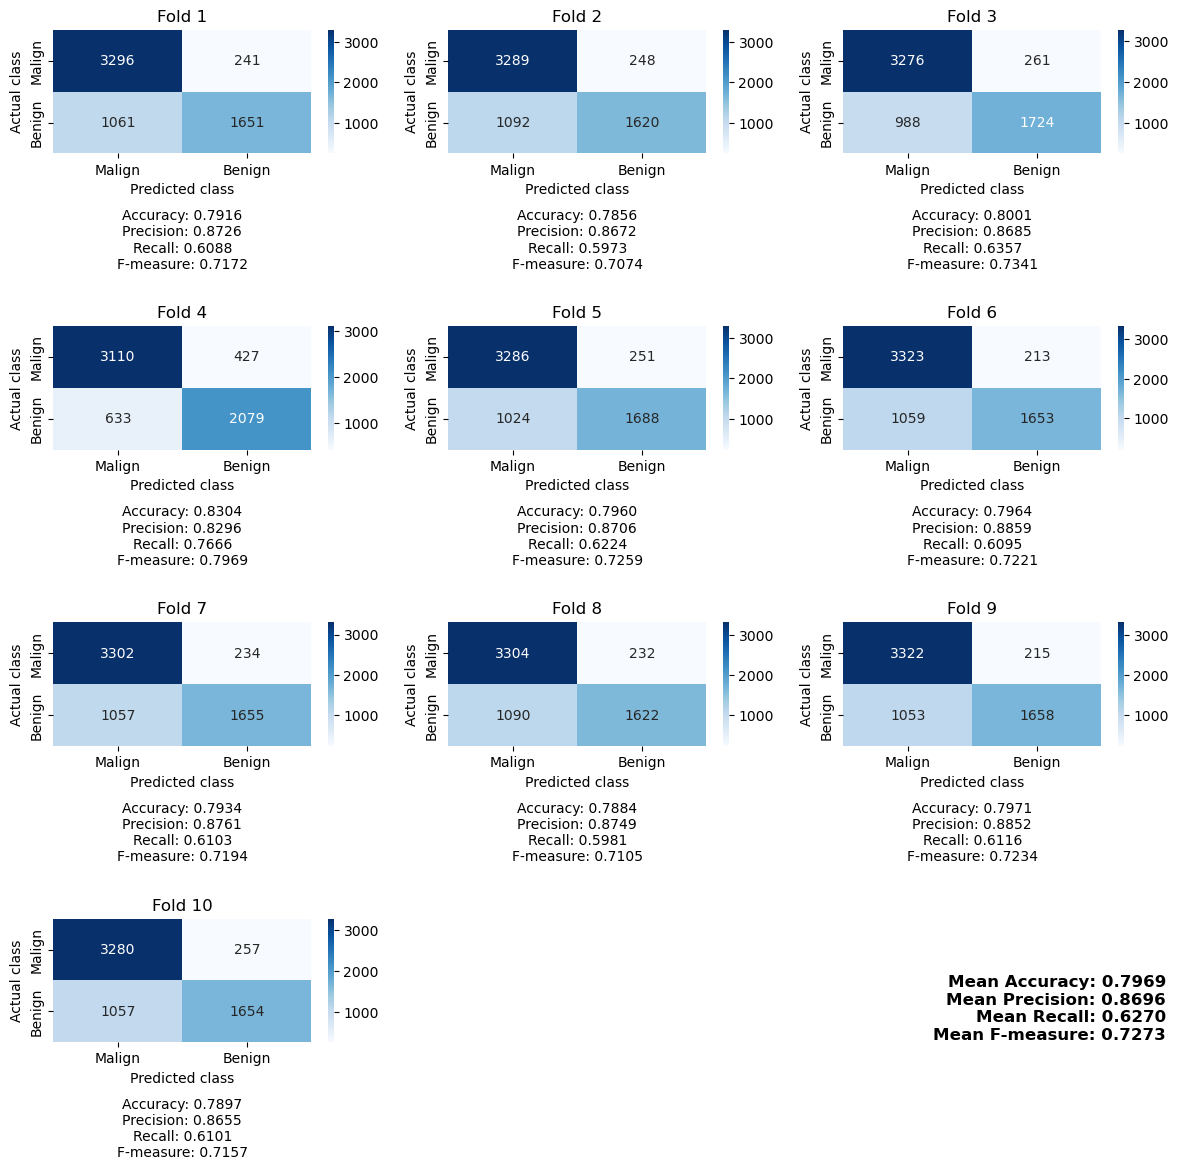

In [8]:
X = df[numeric_columns]
y = df['Benign']

preprocessor = ColumnTransformer(
    transformers=[
        ('num_scaler', StandardScaler(), numeric_columns)  # Applica lo StandardScaler alle variabili numeriche
    ]
)

pipeline = Pipeline(steps=[
    ('preprocessor', preprocessor),         
    ('classifier', LogisticRegression())     
])

cv = StratifiedKFold(n_splits=10, shuffle=True, random_state=42)

accuracy_list = []
precision_list = []
recall_list = []
f1_list = []
conf_matrices = []

# create figure with subplots (max 3 columns for each row)
fig, axes = plt.subplots(4, 3, figsize=(12, 12))
axes = axes.flatten()

# iterate on folds
for i, (train_idx, test_idx) in enumerate(cv.split(X, y)):
    X_train, X_test = X.iloc[train_idx], X.iloc[test_idx]
    y_train, y_test = y.iloc[train_idx], y.iloc[test_idx]

    pipeline.fit(X_train, y_train)          # train the model on the current fold
    
    y_pred = pipeline.predict(X_test)       # obtain the predictions

    # Compute metrics
    acc = accuracy_score(y_test, y_pred)
    prec = precision_score(y_test, y_pred)
    rec = recall_score(y_test, y_pred)
    f1 = f1_score(y_test, y_pred)

    accuracy_list.append(acc)
    precision_list.append(prec)
    recall_list.append(rec)
    f1_list.append(f1)

    cm = confusion_matrix(y_test, y_pred)   # compute the confusion matrix
    conf_matrices.append(cm)

    # plot the confusion matrix
    sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", xticklabels=["Malign", "Benign"], 
                yticklabels=["Malign", "Benign"], ax=axes[i])
    metrics_text = f"Accuracy: {acc:.4f}\nPrecision: {prec:.4f}\nRecall: {rec:.4f}\nF-measure: {f1:.4f}"
    axes[i].text(0.5, -0.7, metrics_text, ha='center', va='center', transform=axes[i].transAxes, fontsize=10)

    axes[i].set_title(f"Fold {i+1}")
    axes[i].set_xlabel("Predicted class")
    axes[i].set_ylabel("Actual class")

# Remove empty subplots if folds < 12
for j in range(i + 1, len(axes)):
    fig.delaxes(axes[j])

# Print the mean of metrcs in the figure
ax_final = fig.add_subplot(111, frameon=False)  
ax_final.axis('off')

final_metrics_text = (
    f"Mean Accuracy: {np.mean(accuracy_list):.4f}\n"
    f"Mean Precision: {np.mean(precision_list):.4f}\n"
    f"Mean Recall: {np.mean(recall_list):.4f}\n"
    f"Mean F-measure: {np.mean(f1_list):.4f}"
)

ax_final.text(1, 0, final_metrics_text, ha='right', va='bottom', fontsize=12, fontweight='bold')


plt.subplots_adjust(hspace=0.7, wspace=0.3)
plt.tight_layout()
plt.show()

### Test 2: Consider only categorical variables (LogisticRegression)

In this second test, we exploit categorical variables to train and evaluate the Logistic Regression model. Before training the model, it is necessary to apply preprocessing to encode the categorical features. We achive this by using One Hot Encoder, which transforms categorical variables into binary vectors.

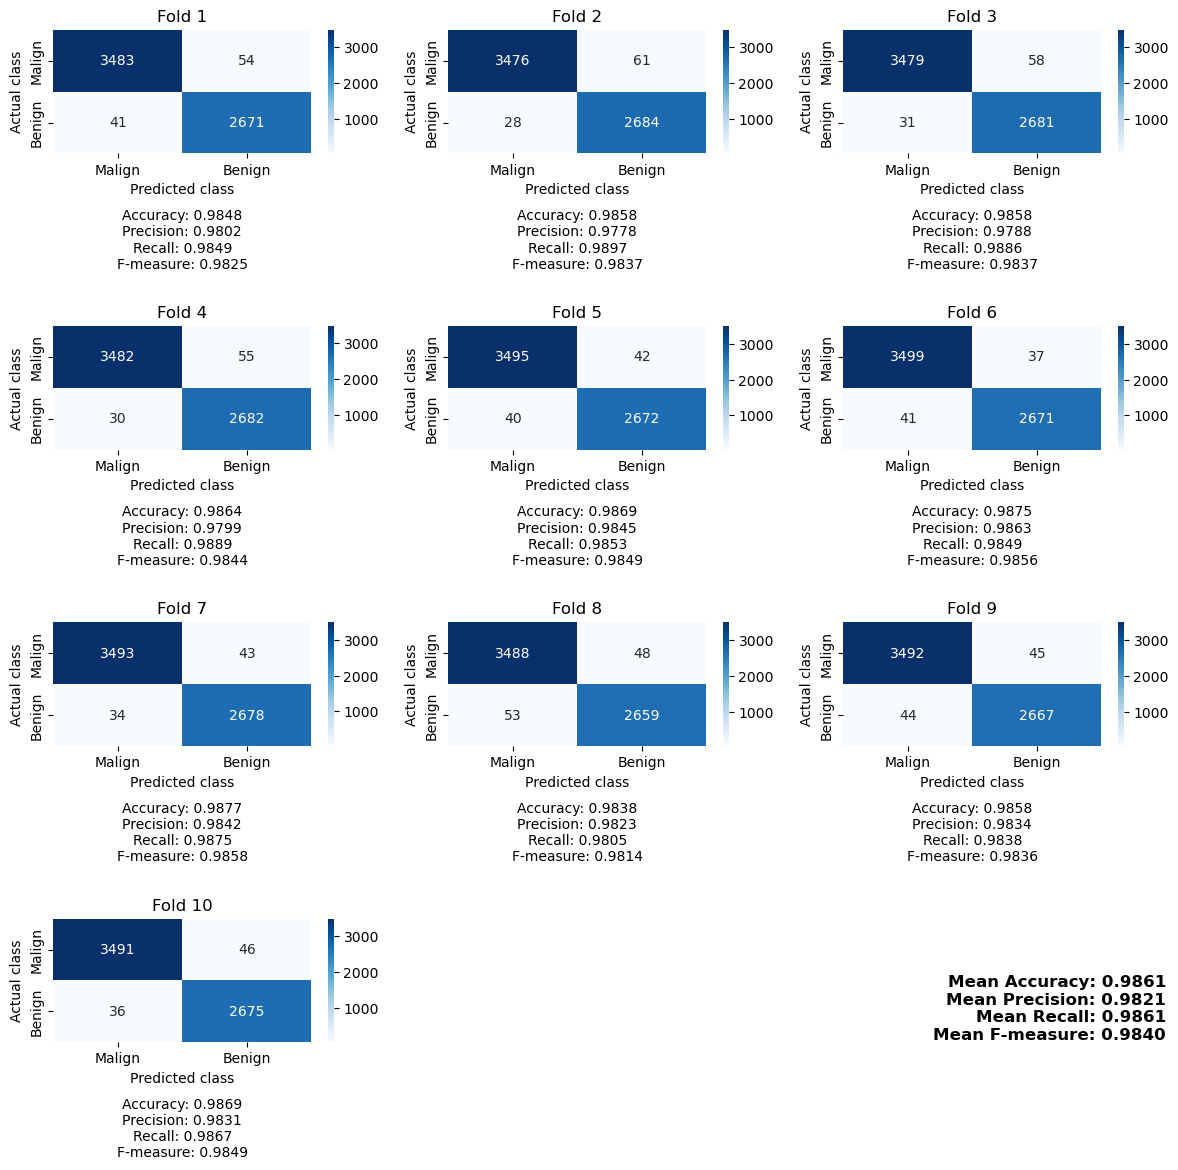

In [9]:
X = df[categorical_columns]
y = df['Benign']

preprocessor = ColumnTransformer(
    transformers=[
        ('cat_transform', OneHotEncoder(handle_unknown='ignore'), categorical_columns)
    ]
)

pipeline = Pipeline(steps=[
    ('preprocessor', preprocessor),
    ('classifier', LogisticRegression(max_iter=1000))
])

cv = StratifiedKFold(n_splits=10, shuffle=True, random_state=42)

accuracy_list = []
precision_list = []
recall_list = []
f1_list = []
conf_matrices = []

# create figure with subplots (max 3 columns for each row)
fig, axes = plt.subplots(4, 3, figsize=(12, 12))
axes = axes.flatten()

# iterate on folds
for i, (train_idx, test_idx) in enumerate(cv.split(X, y)):
    X_train, X_test = X.iloc[train_idx], X.iloc[test_idx]
    y_train, y_test = y.iloc[train_idx], y.iloc[test_idx]

    pipeline.fit(X_train, y_train)          # train the model on the current fold
    
    y_pred = pipeline.predict(X_test)       # obtain the predictions

    # Compute metrics
    acc = accuracy_score(y_test, y_pred)
    prec = precision_score(y_test, y_pred)
    rec = recall_score(y_test, y_pred)
    f1 = f1_score(y_test, y_pred)

    accuracy_list.append(acc)
    precision_list.append(prec)
    recall_list.append(rec)
    f1_list.append(f1)

    cm = confusion_matrix(y_test, y_pred)   # compute the confusion matrix
    conf_matrices.append(cm)

    # plot the confusion matrix
    sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", xticklabels=["Malign", "Benign"], 
                yticklabels=["Malign", "Benign"], ax=axes[i])
    metrics_text = f"Accuracy: {acc:.4f}\nPrecision: {prec:.4f}\nRecall: {rec:.4f}\nF-measure: {f1:.4f}"
    axes[i].text(0.5, -0.7, metrics_text, ha='center', va='center', transform=axes[i].transAxes, fontsize=10)

    axes[i].set_title(f"Fold {i+1}")
    axes[i].set_xlabel("Predicted class")
    axes[i].set_ylabel("Actual class")

# Remove empty subplots if folds < 12
for j in range(i + 1, len(axes)):
    fig.delaxes(axes[j])

# Print the mean of metrcs in the figure
ax_final = fig.add_subplot(111, frameon=False)  
ax_final.axis('off')

final_metrics_text = (
    f"Mean Accuracy: {np.mean(accuracy_list):.4f}\n"
    f"Mean Precision: {np.mean(precision_list):.4f}\n"
    f"Mean Recall: {np.mean(recall_list):.4f}\n"
    f"Mean F-measure: {np.mean(f1_list):.4f}"
)

ax_final.text(1, 0, final_metrics_text, ha='right', va='bottom', fontsize=12, fontweight='bold')


plt.subplots_adjust(hspace=0.7, wspace=0.3)
plt.tight_layout()
plt.show()

f1_list_lr_cat = f1_list
accuracy_list_lr_cat = accuracy_list

### Test 3: Consider the entire dataset (LogisticRegression)

In this test, we trained a Logistic Regression classifier using the entire dataset. To do so, we implemented a structured pre-processing phase consisting of the following steps:
- Normalization of numerical features to account for differences in scale.
- Encoding of categorical features to make them suitable for the model.
- Feature selection to reduce redundancy and enhance accuracy.

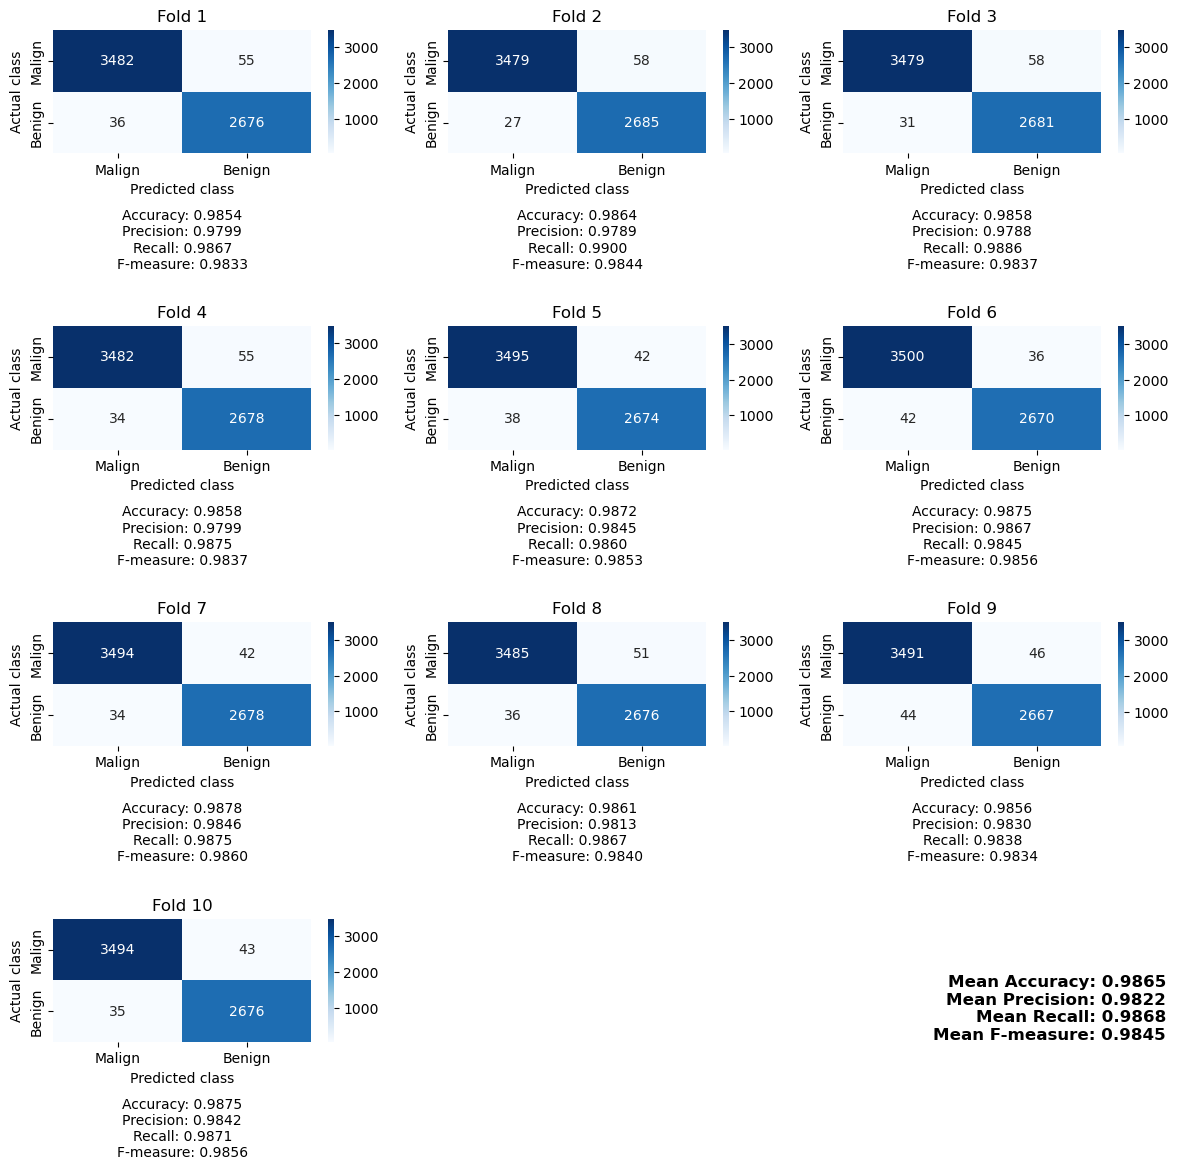

In [10]:
X = df.drop(columns=['Benign'])
y = df['Benign']

preprocessor = ColumnTransformer(
    transformers=[
        ('num_transform', Pipeline(steps=[
            ('scaler', StandardScaler())  # Normalizzazione
        ]), numeric_columns),
        ('cat_transform', Pipeline(steps=[
            ('onehot', OneHotEncoder(handle_unknown='ignore'))  # OneHotEncoding
        ]), categorical_columns)
    ])

pipeline = Pipeline(steps=[
    ('preprocessor', preprocessor),
    ('feature_selection', SelectFromModel(estimator=LogisticRegression(max_iter=1000))),  # Feature Selectio
    ('classifier', LogisticRegression(max_iter=1000))  # Logistic Regression
])

cv = StratifiedKFold(n_splits=10, shuffle=True, random_state=42)

accuracy_list = []
precision_list = []
recall_list = []
f1_list = []
conf_matrices = []

# create figure with subplots (max 3 columns for each row)
fig, axes = plt.subplots(4, 3, figsize=(12, 12))
axes = axes.flatten()

# iterate on folds
for i, (train_idx, test_idx) in enumerate(cv.split(X, y)):
    X_train, X_test = X.iloc[train_idx], X.iloc[test_idx]
    y_train, y_test = y.iloc[train_idx], y.iloc[test_idx]

    pipeline.fit(X_train, y_train)          # train the model on the current fold
    
    y_pred = pipeline.predict(X_test)       # obtain the predictions

    # Compute metrics
    acc = accuracy_score(y_test, y_pred)
    prec = precision_score(y_test, y_pred)
    rec = recall_score(y_test, y_pred)
    f1 = f1_score(y_test, y_pred)

    accuracy_list.append(acc)
    precision_list.append(prec)
    recall_list.append(rec)
    f1_list.append(f1)

    cm = confusion_matrix(y_test, y_pred)   # compute the confusion matrix
    conf_matrices.append(cm)

    # plot the confusion matrix
    sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", xticklabels=["Malign", "Benign"], 
                yticklabels=["Malign", "Benign"], ax=axes[i])
    metrics_text = f"Accuracy: {acc:.4f}\nPrecision: {prec:.4f}\nRecall: {rec:.4f}\nF-measure: {f1:.4f}"
    axes[i].text(0.5, -0.7, metrics_text, ha='center', va='center', transform=axes[i].transAxes, fontsize=10)

    axes[i].set_title(f"Fold {i+1}")
    axes[i].set_xlabel("Predicted class")
    axes[i].set_ylabel("Actual class")

# Remove empty subplots if folds < 12
for j in range(i + 1, len(axes)):
    fig.delaxes(axes[j])

# Print the mean of metrcs in the figure
ax_final = fig.add_subplot(111, frameon=False)  
ax_final.axis('off')

final_metrics_text = (
    f"Mean Accuracy: {np.mean(accuracy_list):.4f}\n"
    f"Mean Precision: {np.mean(precision_list):.4f}\n"
    f"Mean Recall: {np.mean(recall_list):.4f}\n"
    f"Mean F-measure: {np.mean(f1_list):.4f}"
)

ax_final.text(1, 0, final_metrics_text, ha='right', va='bottom', fontsize=12, fontweight='bold')


plt.subplots_adjust(hspace=0.7, wspace=0.3)
plt.tight_layout()
plt.show()

### Conclusions on Logistic Regression classifier

From our experiments with Logistic Regression, we observed significant differences in performances depending on the type of features used.

When trained solely on numerical variables, the model achieved a moderate accuracy of 0.7969, with a relatively high precision (0.8696) but a low recall (0.6270). This shows that when the model predicts a benign instance, it does so correctly 87% of the time. This is not an acceptable result, especially considering the importance of minimizing the risk of falsely classifying malware as benign. On the other hand, the low recall suggests that the model is only able to correctly identify around 63% of the actual benign instances, meaning a significant portion of benign software is being missed. 

When trained only on categorical variables, the model showed an improvement across all metrics, reaching a mean accuracy of 0.9861, precision of 0.9821, and recall of 0.9861. These results indicate that the Logistic Regression model trained with categorical variables significantly outperformed the model trained with numerical variables across all metrics.

Finally, when using the entire dataset (both numerical and categorical variables), the performance remained consistently high, with a mean accuracy of 0.9865, precision of 0.9822, and recall of 0.9845. While this configuration performed slightly better than the categorical-only model, the improvement was minimal, suggesting that numerical features contributed little additional value beyond what was already captured by categorical variables.

In conclusion, our results indicate that categorical variables play a crucial role in classification. The Logistic Regression model trained exclusively on categorical features already achieved near-optimal results, and incorporating numerical features did not provide a substantial benefit.

Now, we test the classification as in the previous cases but using Random Forest classifier.

### Test 4: Consider only numerical features (Random Forest)

Here, we use numerical variables to train the Random Forest classifier. In this case, we do not scale variables because Random Forest is based on decision trees, which are scale invariant. Decision trees work by creating thresholds on numerical features to split data, effectively discretizing the continuous values into intervals that help in decision-making. This process is not influenced by the scale of the variables, so scaling is unnecessary.

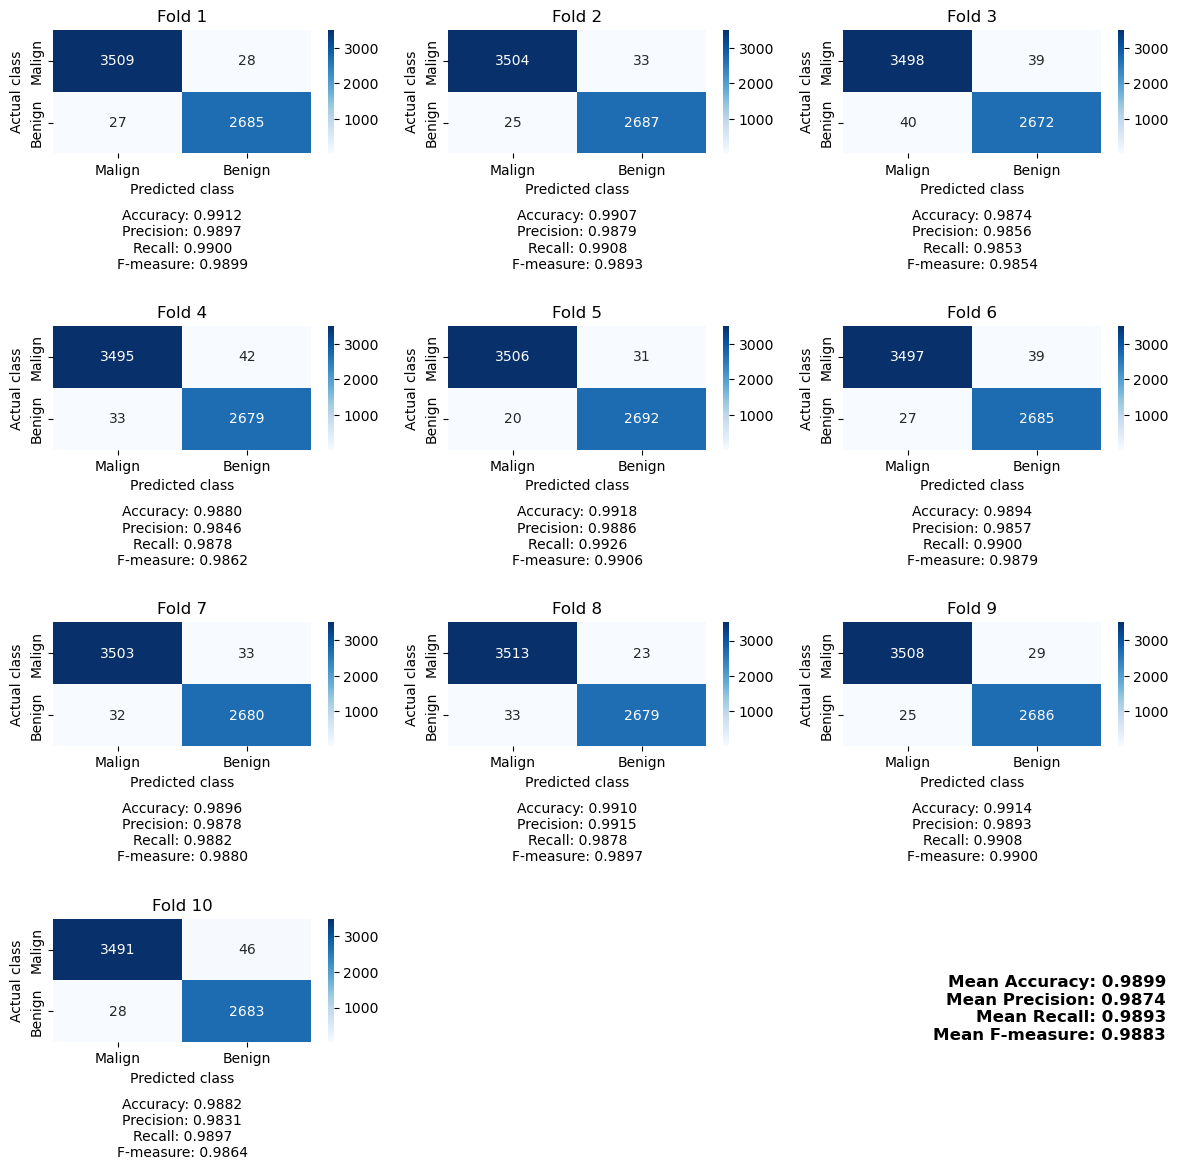

In [11]:
X = df[numeric_columns]
y = df['Benign']

pipeline = Pipeline(steps=[     
    ('classifier', RandomForestClassifier())     
])

cv = StratifiedKFold(n_splits=10, shuffle=True, random_state=42)

accuracy_list = []
precision_list = []
recall_list = []
f1_list = []
conf_matrices = []

# create figure with subplots (max 3 columns for each row)
fig, axes = plt.subplots(4, 3, figsize=(12, 12))
axes = axes.flatten()

# iterate on folds
for i, (train_idx, test_idx) in enumerate(cv.split(X, y)):
    X_train, X_test = X.iloc[train_idx], X.iloc[test_idx]
    y_train, y_test = y.iloc[train_idx], y.iloc[test_idx]

    pipeline.fit(X_train, y_train)          # train the model on the current fold
    
    y_pred = pipeline.predict(X_test)       # obtain the predictions

    # Compute metrics
    acc = accuracy_score(y_test, y_pred)
    prec = precision_score(y_test, y_pred)
    rec = recall_score(y_test, y_pred)
    f1 = f1_score(y_test, y_pred)

    accuracy_list.append(acc)
    precision_list.append(prec)
    recall_list.append(rec)
    f1_list.append(f1)

    cm = confusion_matrix(y_test, y_pred)   # compute the confusion matrix
    conf_matrices.append(cm)

    # plot the confusion matrix
    sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", xticklabels=["Malign", "Benign"], 
                yticklabels=["Malign", "Benign"], ax=axes[i])
    metrics_text = f"Accuracy: {acc:.4f}\nPrecision: {prec:.4f}\nRecall: {rec:.4f}\nF-measure: {f1:.4f}"
    axes[i].text(0.5, -0.7, metrics_text, ha='center', va='center', transform=axes[i].transAxes, fontsize=10)

    axes[i].set_title(f"Fold {i+1}")
    axes[i].set_xlabel("Predicted class")
    axes[i].set_ylabel("Actual class")

# Remove empty subplots if folds < 12
for j in range(i + 1, len(axes)):
    fig.delaxes(axes[j])

# Print the mean of metrcs in the figure
ax_final = fig.add_subplot(111, frameon=False)  
ax_final.axis('off')

final_metrics_text = (
    f"Mean Accuracy: {np.mean(accuracy_list):.4f}\n"
    f"Mean Precision: {np.mean(precision_list):.4f}\n"
    f"Mean Recall: {np.mean(recall_list):.4f}\n"
    f"Mean F-measure: {np.mean(f1_list):.4f}"
)

ax_final.text(1, 0, final_metrics_text, ha='right', va='bottom', fontsize=12, fontweight='bold')


plt.subplots_adjust(hspace=0.7, wspace=0.3)
plt.tight_layout()
plt.show()

### Test 5: Consider only categorical features (RandomForest)

In this test, we exploit categorical variables to train and evaluate the Random Forsest classifier. In this case, since we're using Random Forest as classifier, we don't encode the categorical columns with One Hot Encoding.

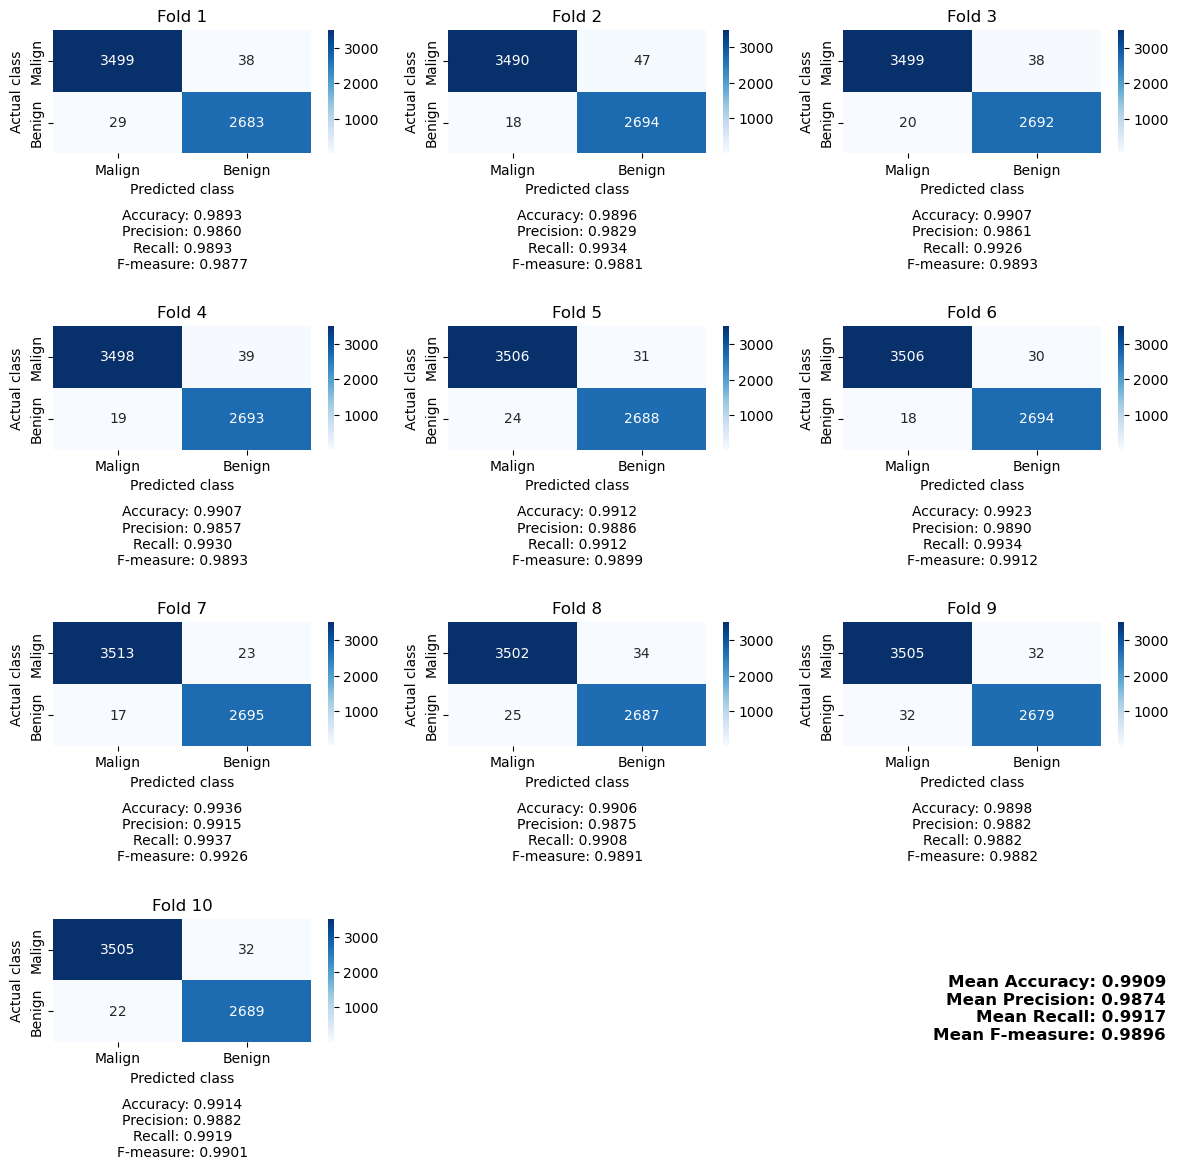

In [12]:
X = df[categorical_columns]
y = df['Benign']


pipeline = Pipeline(steps=[
    ('classifier', RandomForestClassifier())
])

cv = StratifiedKFold(n_splits=10, shuffle=True, random_state=42)

accuracy_list = []
precision_list = []
recall_list = []
f1_list = []
conf_matrices = []

# create figure with subplots (max 3 columns for each row)
fig, axes = plt.subplots(4, 3, figsize=(12, 12))
axes = axes.flatten()

# iterate on folds
for i, (train_idx, test_idx) in enumerate(cv.split(X, y)):
    X_train, X_test = X.iloc[train_idx], X.iloc[test_idx]
    y_train, y_test = y.iloc[train_idx], y.iloc[test_idx]

    pipeline.fit(X_train, y_train)          # train the model on the current fold
    
    y_pred = pipeline.predict(X_test)       # obtain the predictions

    # Compute metrics
    acc = accuracy_score(y_test, y_pred)
    prec = precision_score(y_test, y_pred)
    rec = recall_score(y_test, y_pred)
    f1 = f1_score(y_test, y_pred)

    accuracy_list.append(acc)
    precision_list.append(prec)
    recall_list.append(rec)
    f1_list.append(f1)

    cm = confusion_matrix(y_test, y_pred)   # compute the confusion matrix
    conf_matrices.append(cm)

    # plot the confusion matrix
    sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", xticklabels=["Malign", "Benign"], 
                yticklabels=["Malign", "Benign"], ax=axes[i])
    metrics_text = f"Accuracy: {acc:.4f}\nPrecision: {prec:.4f}\nRecall: {rec:.4f}\nF-measure: {f1:.4f}"
    axes[i].text(0.5, -0.7, metrics_text, ha='center', va='center', transform=axes[i].transAxes, fontsize=10)

    axes[i].set_title(f"Fold {i+1}")
    axes[i].set_xlabel("Predicted class")
    axes[i].set_ylabel("Actual class")

# Remove empty subplots if folds < 12
for j in range(i + 1, len(axes)):
    fig.delaxes(axes[j])

# Print the mean of metrcs in the figure
ax_final = fig.add_subplot(111, frameon=False)  
ax_final.axis('off')

final_metrics_text = (
    f"Mean Accuracy: {np.mean(accuracy_list):.4f}\n"
    f"Mean Precision: {np.mean(precision_list):.4f}\n"
    f"Mean Recall: {np.mean(recall_list):.4f}\n"
    f"Mean F-measure: {np.mean(f1_list):.4f}"
)

ax_final.text(1, 0, final_metrics_text, ha='right', va='bottom', fontsize=12, fontweight='bold')


plt.subplots_adjust(hspace=0.7, wspace=0.3)
plt.tight_layout()
plt.show()

f1_list_rf_cat = f1_list
accuracy_list_rf_cat = accuracy_list

### Test 6: Consider entire dataset (Random Forest)

In this sixth test, we train the Random Forest model using the entire dataset. As with the previous case, normalization is not required because Random Forest is based on decision trees, which are scale-invariant. Additionally, feature selection is not necessary because Random Forest inherently handles it during the tree construction process. At each node, the algorithm randomly samples a subset of features to ensure that the decision trees are built differently.

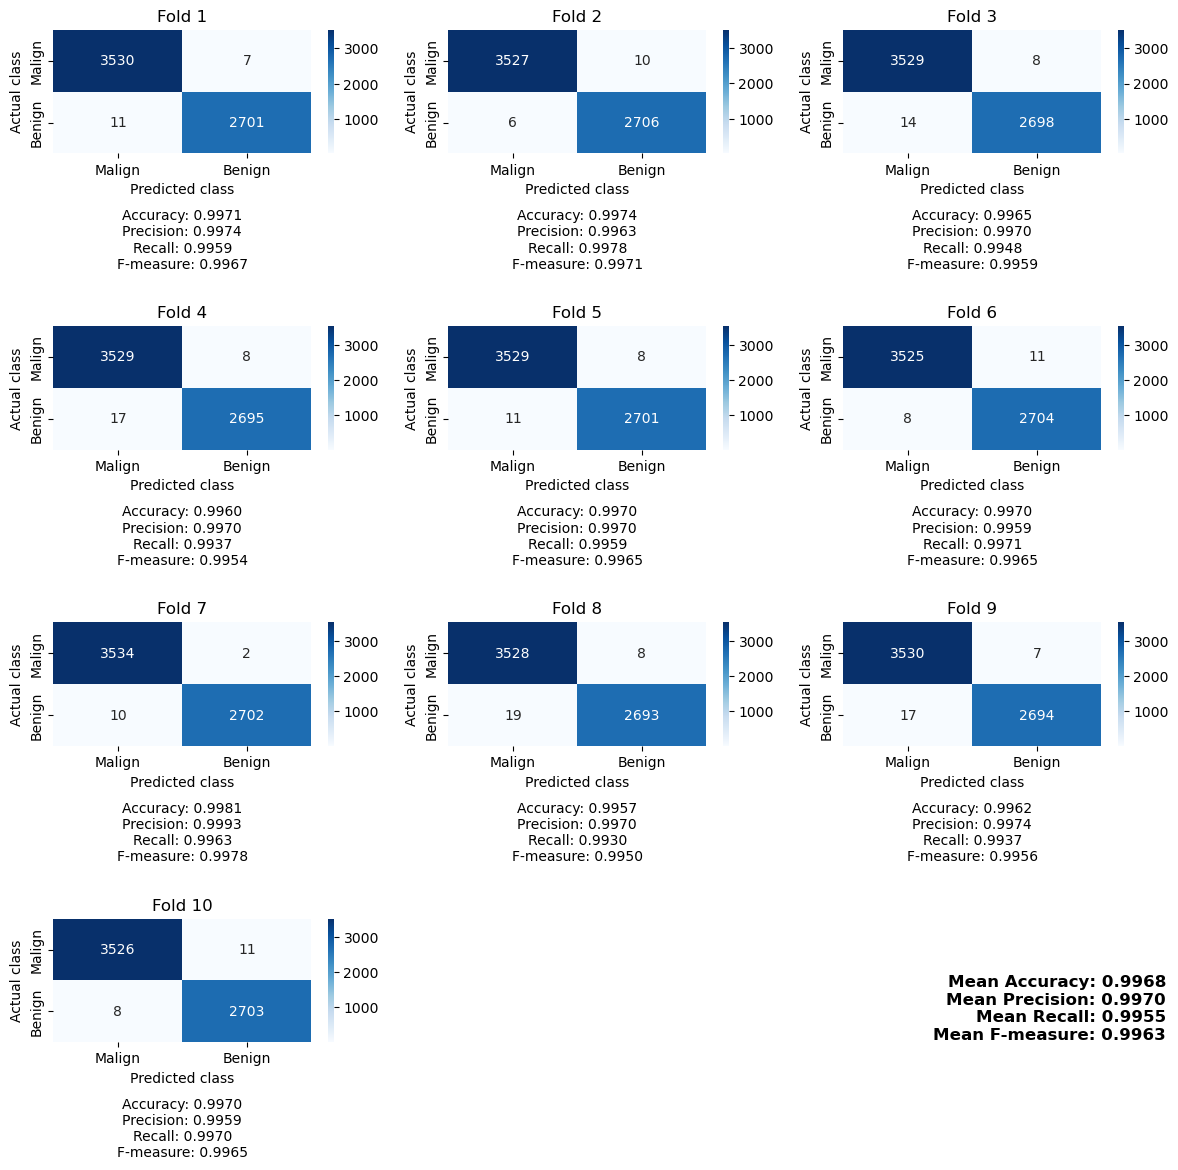

In [13]:
X = df.drop(columns=['Benign'])
y = df['Benign']

pipeline = Pipeline(steps=[
    ('classifier', RandomForestClassifier())
])

cv = StratifiedKFold(n_splits=10, shuffle=True, random_state=42)

accuracy_list = []
precision_list = []
recall_list = []
f1_list = []
conf_matrices = []

# create figure with subplots (max 3 columns for each row)
fig, axes = plt.subplots(4, 3, figsize=(12, 12))
axes = axes.flatten()

# iterate on folds
for i, (train_idx, test_idx) in enumerate(cv.split(X, y)):
    X_train, X_test = X.iloc[train_idx], X.iloc[test_idx]
    y_train, y_test = y.iloc[train_idx], y.iloc[test_idx]

    pipeline.fit(X_train, y_train)          # train the model on the current fold
    
    y_pred = pipeline.predict(X_test)       # obtain the predictions

    # Compute metrics
    acc = accuracy_score(y_test, y_pred)
    prec = precision_score(y_test, y_pred)
    rec = recall_score(y_test, y_pred)
    f1 = f1_score(y_test, y_pred)

    accuracy_list.append(acc)
    precision_list.append(prec)
    recall_list.append(rec)
    f1_list.append(f1)

    cm = confusion_matrix(y_test, y_pred)   # compute the confusion matrix
    conf_matrices.append(cm)

    # plot the confusion matrix
    sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", xticklabels=["Malign", "Benign"], 
                yticklabels=["Malign", "Benign"], ax=axes[i])
    metrics_text = f"Accuracy: {acc:.4f}\nPrecision: {prec:.4f}\nRecall: {rec:.4f}\nF-measure: {f1:.4f}"
    axes[i].text(0.5, -0.7, metrics_text, ha='center', va='center', transform=axes[i].transAxes, fontsize=10)

    axes[i].set_title(f"Fold {i+1}")
    axes[i].set_xlabel("Predicted class")
    axes[i].set_ylabel("Actual class")

# Remove empty subplots if folds < 12
for j in range(i + 1, len(axes)):
    fig.delaxes(axes[j])

# Print the mean of metrcs in the figure
ax_final = fig.add_subplot(111, frameon=False)  
ax_final.axis('off')

final_metrics_text = (
    f"Mean Accuracy: {np.mean(accuracy_list):.4f}\n"
    f"Mean Precision: {np.mean(precision_list):.4f}\n"
    f"Mean Recall: {np.mean(recall_list):.4f}\n"
    f"Mean F-measure: {np.mean(f1_list):.4f}"
)

ax_final.text(1, 0, final_metrics_text, ha='right', va='bottom', fontsize=12, fontweight='bold')


plt.subplots_adjust(hspace=0.7, wspace=0.3)
plt.tight_layout()
plt.show()

### Conclusions on Random Forest classifier

Based on the results from the tests using Random Forest classifier, we can draw the following conclusions:

When training the model using only numerical variables, the mean accuracy of 0.9899 suggests that the model performs very well in correctly classifying instances. The mean precision of 0.9874 indicates that when the model predicts a benign instance, it is correct 98.74% of the time, showing a low false positive rate. The mean recall of 0.9893 implies that the model is able to correctly identify 98.93% of all benign instances.

When the model is trained with only categorical features, the mean accuracy of 0.9909 demonstrates a slightly better performance than the case with only numerical variables, with 99.09% of predictions being correct. The mean precision of 0.9874 is nearly identical to the previous case. The mean recall of 0.9917 is slightly higher than in the previous case, indicating that the model is able to identify 99.17% of benign instances, with even fewer benign instances missed.

Finally, in the case of training the model with the entire dataset, the mean accuracy of 0.9968 is the highest of the three cases, suggesting that combining both numerical and categorical features provides the best performance. The mean precision of 0.9970 is consistent with the previous cases, showing that the model maintains a low false positive rate. The mean recall of 0.9955 remains unchanged from the case of categorical variables alone, indicating that the addition of numerical features does not significantly affect the recall performance.

The Random Forest classifier performs consistently well across all cases, with the highest performance observed when using the entire dataset, which includes both numerical and categorical variables. The model demonstrates a good balance between accuracy, precision, and recall, making it effective in correctly identifying benign instances while minimizing false positives. The inclusion of both numerical and categorical variables slightly improves accuracy, but the recall remains the same as with categorical variables alone. 

### Comparison between models

To compare the two classifiers in the scenarios of only categorical features, we cannot rely solely on the mean F-measures or accuracy. Instead, we aim to use a statistical test: the T-test.

Since the T-test assumes that the distributions of F-measures or accuracy for each classifier follow a Gaussian distribution, we first plot these distributions to verify this assumption, and then apply the T-test to assess whether the differences in performance between the classifiers are statistically significant.

If we obtain statistical evidence of a significant difference, we can then compare the mean F-measures (or accuracy) of the different models to determine which classifier performs better.

#### Distibution visualizztion of F-measures and accuracies

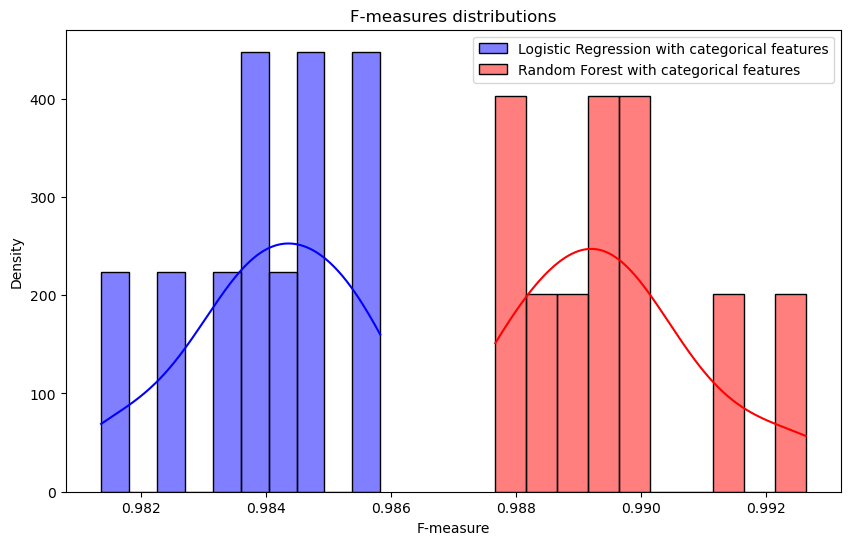

In [14]:
plt.figure(figsize=(10, 6))
sns.histplot(f1_list_lr_cat, kde=True, color="blue", label="Logistic Regression with categorical features", stat="density", bins=10)
sns.histplot(f1_list_rf_cat, kde=True, color="red", label="Random Forest with categorical features", stat="density", bins=10)

plt.title('F-measures distributions')
plt.xlabel('F-measure')
plt.ylabel('Density')
plt.legend()
plt.show()

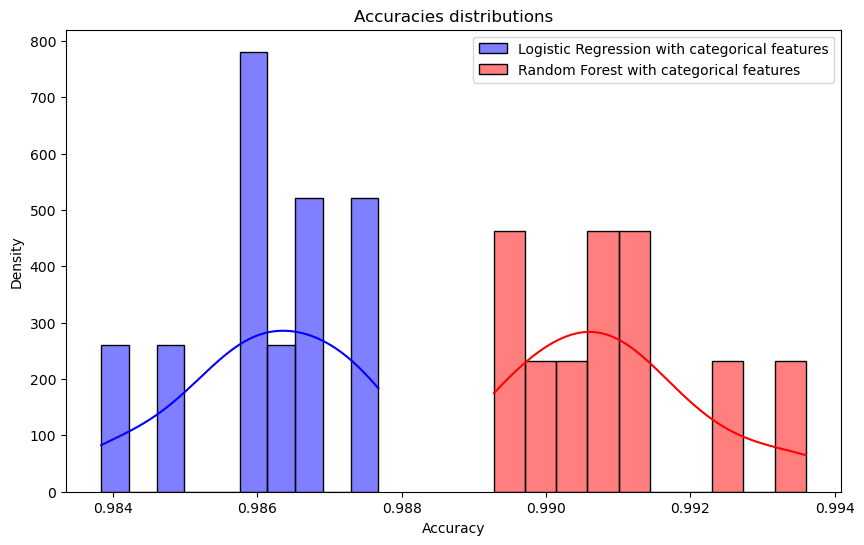

In [15]:
plt.figure(figsize=(10, 6))
sns.histplot(accuracy_list_lr_cat, kde=True, color="blue", label="Logistic Regression with categorical features", stat="density", bins=10)
sns.histplot(accuracy_list_rf_cat, kde=True, color="red", label="Random Forest with categorical features", stat="density", bins=10)

plt.title('Accuracies distributions')
plt.xlabel('Accuracy')
plt.ylabel('Density')
plt.legend()
plt.show()

As we can see from these plots, even though the number of samples is quite low, we can see the Gaussian Bell quite clearly for both the F-Measures and Accuracies

#### Compute t-test

In [16]:
# t-test for F-measures
from scipy.stats import ttest_ind

t_stat, p_value = ttest_ind(f1_list_lr_cat, f1_list_rf_cat)

print(f"t-statistic: {t_stat:.10f}")
print(f"p-value: {p_value:.10f}")

t-statistic: -8.5314206501
p-value: 0.0000000969


In [17]:
# t-test for accuracy
from scipy.stats import ttest_ind

t_stat, p_value = ttest_ind(accuracy_list_lr_cat, accuracy_list_rf_cat)

print(f"t-statistic: {t_stat:.10f}")
print(f"p-value: {p_value:.10f}")

t-statistic: -8.5245244540
p-value: 0.0000000981


#### Final model comparison

Given the statistical evidence of the difference in performance between the two models, we can conclude that, since Random Forest is better in both accuracy (0.9919 vs 0.9861) and F-measure (0.9896 vs 0.9840), it performs better than Logistic Regression.

However, given the little difference between Random Forest and Logisic Regression in terms of metrics, Logistic Regression can be better if we consider the explainability of the model. 

We will analyze the explainability of the models in the following part.

